In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from lib.Exercise1_1 import LQRSolver  # Import the LQR Solver from the provided library.
from torch.utils.data import TensorDataset, DataLoader

from matplotlib import rcParams
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap

# Define matrices for LQR problem
H = torch.tensor([[1.2, 0.8], [-0.6, 0.9]], dtype=torch.double)
M = torch.tensor([[0.5,0.7], [0.3,1.0]], dtype=torch.double)
sigma = torch.tensor([[[0.8],[1.1]]], dtype=torch.double)
C = torch.tensor([[1.6, 0.0], [0.0, 1.1]], dtype=torch.double)
D = torch.tensor([[0.5, 0.0], [0.0, 0.7]], dtype=torch.double)
R = torch.tensor([[0.9, 0.0], [0.0, 1.0]], dtype=torch.double)
T = torch.tensor(1.0, dtype=torch.double)

# Initialize LQRSolver
lqr_solver = LQRSolver(H, M, sigma, C, D, R, T=T, method="euler")


In [2]:
# Function to generate new training data for either the value function or control function
def new_data(num_samples, func_to_cal):
    # Generate uniformly distributed time samples within the interval [0, T]
    t_samples = T * torch.rand(num_samples, dtype=torch.double)
    # Define the range of the spatial domain
    x_ends = torch.tensor([-3, 3], dtype=torch.double)
    # Generate uniformly distributed spatial samples within the defined range
    x_samples = x_ends[0] + (x_ends[1] - x_ends[0]) * torch.rand(num_samples, 1, 2, dtype=torch.double)
    
    # If the function to calculate is the value function
    if func_to_cal == 'value':
        # Calculate the value function for the given time and spatial samples
        v_samples = lqr_solver.value_function(t_samples, x_samples)
        # Return time samples, spatial samples, and the calculated value function samples
        return t_samples, x_samples, v_samples
    
    # If the function to calculate is the control function
    if func_to_cal == 'control':
        # Calculate the optimal control for the given time and spatial samples
        alpha_samples = lqr_solver.markov_control(t_samples, x_samples)
        # Return time samples, spatial samples, and the calculated control samples
        return t_samples, x_samples, alpha_samples


In [3]:
# Defines a neural network class for approximating the value function
class ValueFunctionNN(nn.Module):
    def __init__(self):
        # Inherit properties from the parent class nn.Module
        super(ValueFunctionNN, self).__init__()
        # First layer takes 3 inputs (time t and spatial variables x1 and x2) and outputs 100 features
        self.layer1 = nn.Linear(3, 100)  
        # Second and third layers are fully connected layers with 100 neurons each
        self.layer2 = nn.Linear(100, 100)
        self.layer3 = nn.Linear(100, 100)
        # ReLU (Rectified Linear Unit) activation function for introducing non-linearity
        self.relu = nn.ReLU()
        # Output layer: reduces the dimension from 100 to 1, representing the value function
        self.output = nn.Linear(100, 1)
    
    def forward(self, x):
        # Defines the forward pass of the neural network
        # Applies ReLU activation function after each layer except for the output layer
        x = self.relu(self.layer1(x))  # Input passes through the first layer and ReLU
        x = self.relu(self.layer2(x))  # Then, it passes through the second layer and ReLU
        x = self.relu(self.layer3(x))  # Finally, it passes through the third layer and ReLU
        return self.output(x)  # The output layer produces the final value function approximation


In [4]:
# Initializes the model for approximating the value function
model_value = ValueFunctionNN().double()

# Sets up the optimizer with a learning rate of 0.001
# Adam optimizer is used for its adaptive learning rate properties
optimizer_value = torch.optim.Adam(model_value.parameters(), lr=0.001)

# Defines the loss function as Mean Squared Error (MSE) to measure
# the difference between the predicted and true values
criterion_value = nn.MSELoss()

# Initializes a list to store the loss for each epoch, useful for visualizing the training process
epoch_losses = []

# Specifies the batch size and number of epochs for training
batch_size = 5
epochs = 1000

# Training loop over the specified number of batches
for batch in range(batch_size):
    print(f'Batch {batch+1}/{batch_size}'+'\n')
    
    # Generates new data for training
    t_data, x_data, v_data = new_data(10000, 'value')

    # Prepares the input by concatenating time and spatial data
    inputs = torch.cat((t_data.unsqueeze(-1), x_data.squeeze(1)), dim=1)

    # Creates a DataLoader for batch processing
    dataset = TensorDataset(inputs, v_data)
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    # Iterates over each epoch for training
    for epoch in range(epochs):
        model_value.train()  # Sets the model to training mode
        total_loss = 0
        
        # Iterates over each mini-batch
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer_value.zero_grad()  # Clears the gradients of all optimized tensors
            output = model_value(data)  # Forward pass: computes the model's output
            loss = criterion_value(output, target.unsqueeze(1))  # Computes the loss
            loss.backward()  # Backward pass: computes the gradient of the loss w.r.t. the parameters
            optimizer_value.step()  # Updates the parameters
            total_loss += loss.item()  # Aggregates the loss
        
        # Stores the average loss for this epoch
        epoch_losses.append(total_loss / len(dataloader))
        
        # Prints loss information at specific epochs
        if epoch == 0 or (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
    print('\n')


Batch 1/5

Epoch 1/1000 	 Loss: 423.7631800697512
Epoch 100/1000 	 Loss: 0.05861073186109306
Epoch 200/1000 	 Loss: 0.034083726802223026
Epoch 300/1000 	 Loss: 0.021808684562263644
Epoch 400/1000 	 Loss: 0.03917630639002127
Epoch 500/1000 	 Loss: 0.009147376957502026
Epoch 600/1000 	 Loss: 0.009080528133800489
Epoch 700/1000 	 Loss: 0.029627697500152227
Epoch 800/1000 	 Loss: 0.0057037262065167274
Epoch 900/1000 	 Loss: 0.011010835063023767
Epoch 1000/1000 	 Loss: 0.006742903801125695


Batch 2/5

Epoch 1/1000 	 Loss: 0.015654208298070207
Epoch 100/1000 	 Loss: 0.010679160471197994
Epoch 200/1000 	 Loss: 0.007583746857629923
Epoch 300/1000 	 Loss: 0.009323563598247323
Epoch 400/1000 	 Loss: 0.0041237251702796445
Epoch 500/1000 	 Loss: 0.005583750548694187
Epoch 600/1000 	 Loss: 0.004398669614216938
Epoch 700/1000 	 Loss: 0.003162179472895564
Epoch 800/1000 	 Loss: 0.005117303589648949
Epoch 900/1000 	 Loss: 0.0035215025066292253
Epoch 1000/1000 	 Loss: 0.008978981320026886


Batch 3/5


C:\Users\warre\AppData\Local\Temp\ipykernel_27008\3987495554.py:40: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(epoch_losses) - 0.01, max(epoch_losses) + 0.01)


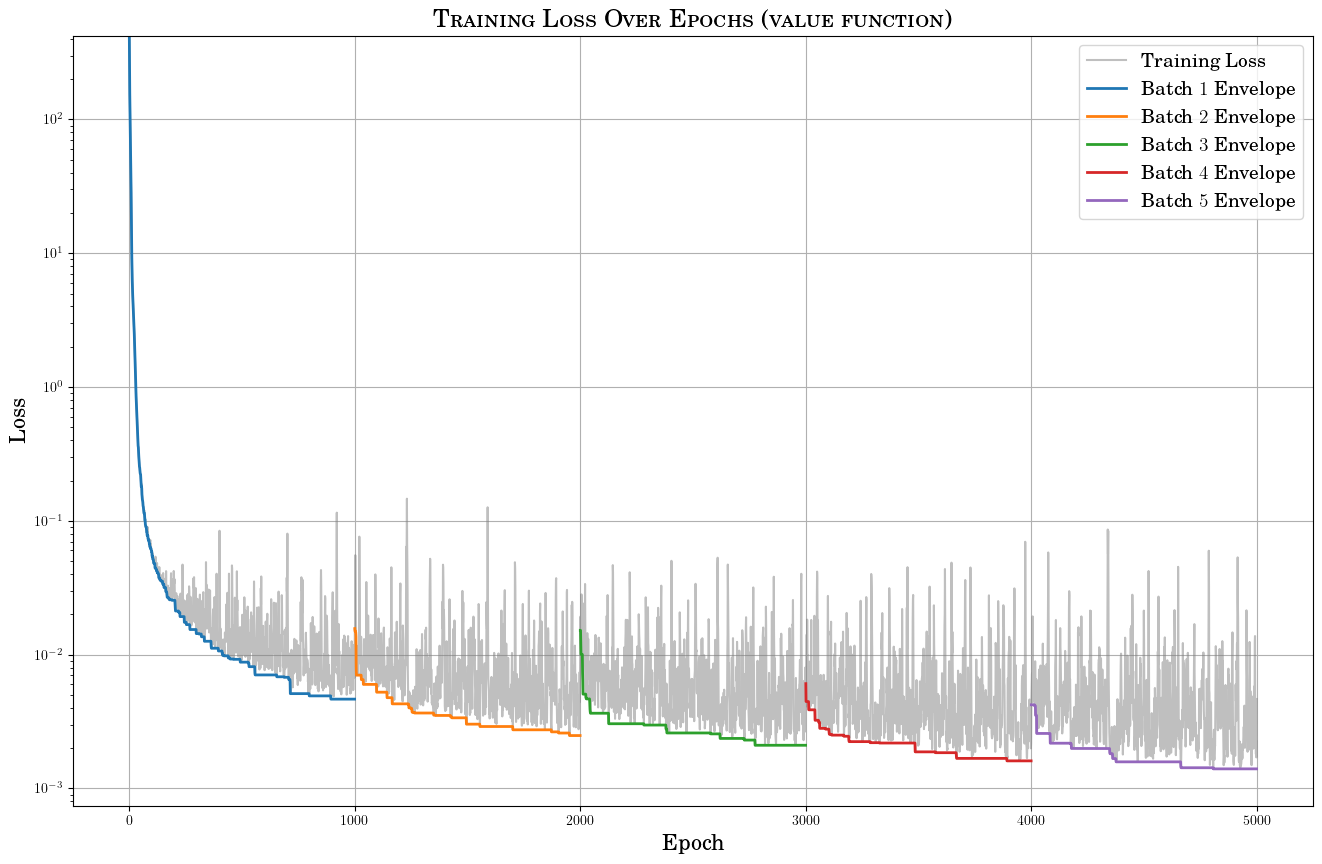

In [5]:
# This script plots the training loss over epochs for the value function approximation model.
# It uses LaTeX for text rendering in the plot for a professional appearance.

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Calculate the envelope of the minimum values accumulated over epochs to highlight the overall trend.
envelope_lower = np.minimum.accumulate(epoch_losses)

plt.figure(figsize=(16, 10))

# Plot the raw training losses as a grey line to show all fluctuations.
plt.plot(epoch_losses, label=r'\rmfamily {\textmd{Training Loss}}', alpha=0.5, color='grey')

# Prepare the epoch indices for each batch's epochs.
epoch_list = range(batch_size * epochs)

# Iterate through each batch to plot the minimum envelope for each batch separately.
for i in range(batch_size):
    start = i * epochs  # Start index for the current batch
    end = (i + 1) * epochs  # End index for the current batch
    batch_epochs = epoch_list[start:end]  # Select the epoch range for the current batch
    batch_losses = epoch_losses[start:end]  # Select the losses for the current batch
    
    # Calculate the envelope for the current batch.
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    # Plot the envelope for the current batch.
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$' r'\textmd{ Envelope}', lw=2)

# Set the y-axis to logarithmic scale to better visualize changes over orders of magnitude.
plt.yscale('log')

# Labeling the axes and setting the title.
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (value function)}}', fontsize=18)

# Adjust the y-axis limits slightly beyond the range of the losses for better visualization.
plt.ylim(min(epoch_losses) - 0.01, max(epoch_losses) + 0.01)

# Add a legend to the plot.
plt.legend(fontsize=14)

# Enable grid for easier reading of values.
plt.grid(True)

# Save the plot to files in both EPS and PNG formats for use in documents and online.
plt.savefig('Exercise2/Training Loss (value function).pdf', format='pdf', dpi=600)
plt.savefig('Exercise2/Training Loss (value function).png', format='png', dpi=600)

# Display the plot.
plt.show()


In [6]:
# Saving the trained value function model for future use or analysis.
torch.save(model_value, 'Exercise2/value_model.pth')

In [7]:
# Visualization setup for comparing the learned value function with the numerical solution.
# Setting time and state space grid for evaluation.

t_ends = [0.1, 0.9]  # Time range for evaluation
t_num = 9  # Number of time steps
x_ends = [[-3, 3], [-3, 3]]  # State space range for each dimension
x_num = [144, 144]  # Number of grid points in each state space dimension

# Generating a batch of time samples uniformly distributed within the specified time range.
t_batch_i = torch.linspace(t_ends[0], t_ends[1], t_num, dtype=torch.double)
t_batch = t_batch_i.repeat_interleave(x_num[0] * x_num[1])  # Replicating for each point in the state space grid

# Generating grids for each state dimension within the specified range.
x1 = torch.linspace(x_ends[0][0], x_ends[0][1], x_num[0], dtype=torch.double)
x2 = torch.linspace(x_ends[1][0], x_ends[1][1], x_num[1], dtype=torch.double)

# Creating a batch of state samples using the cartesian product of the state space grids.
x_batch_i = torch.cartesian_prod(x1, x2).unsqueeze(1)

# Reshaping for easy access to each dimension's values.
X1 = x_batch_i[:, 0, 0].view(x_num[0], x_num[1])
X2 = x_batch_i[:, 0, 1].view(x_num[0], x_num[1])

# Replicating the state samples for each time sample.
x_batch = torch.cartesian_prod(x1, x2).unsqueeze(1).repeat(t_num, 1, 1)

# Using the LQR solver to compute the numerical solution of the value function over the specified grid.
value_numerical = lqr_solver.value_function(t_batch, x_batch)

# The code setup allows for a comprehensive comparison across a dense grid in both time and state space,
# illustrating how well the trained model approximates the true value function as solved by the LQR solver.

In [8]:
# Switching the model to evaluation mode to disable dropout and batch normalization effects during inference.
model_value.eval()

# Generating neural network-based value function predictions for the entire batch of time and state samples.
value_nn = model_value(torch.cat((t_batch.unsqueeze(-1), x_batch.squeeze(1)), dim=1)).squeeze()


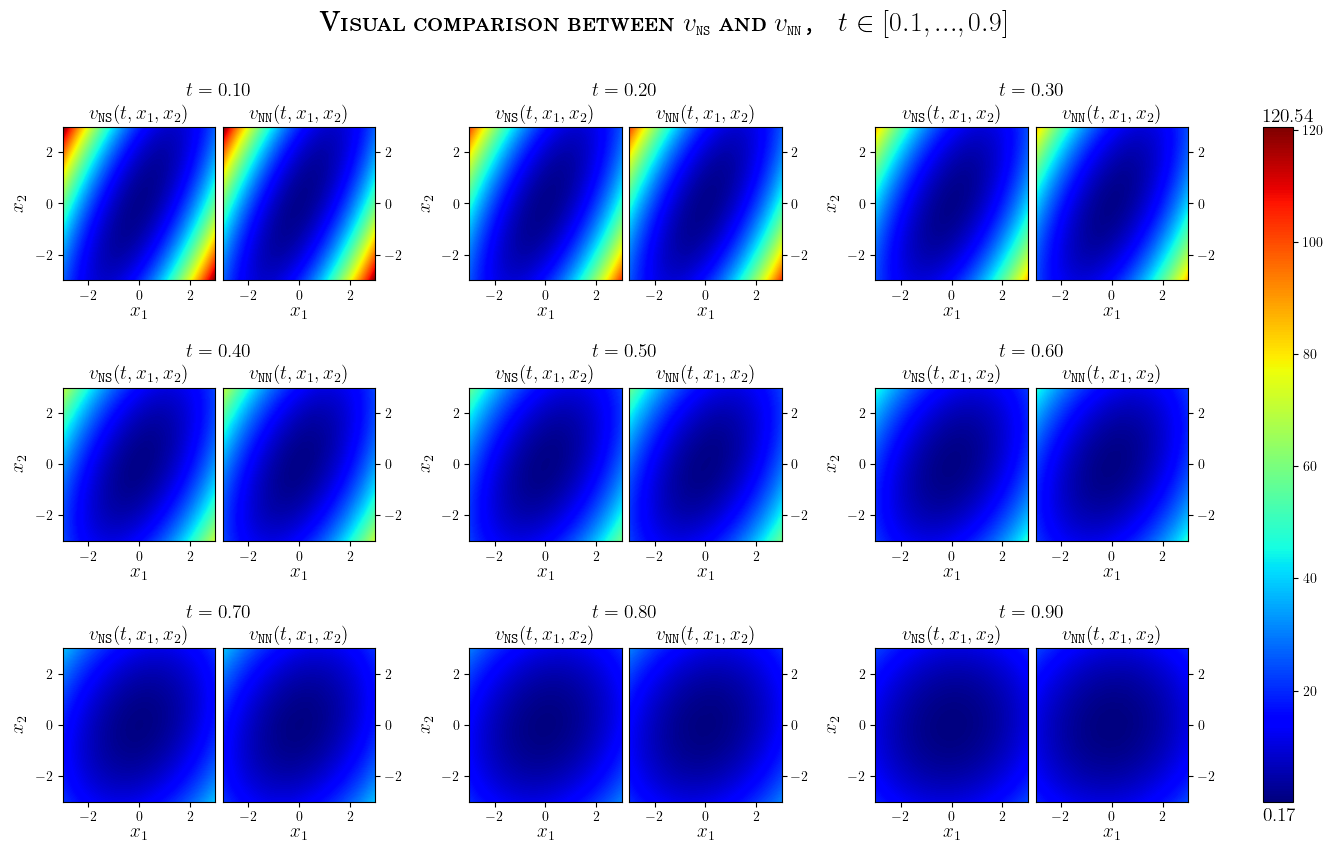

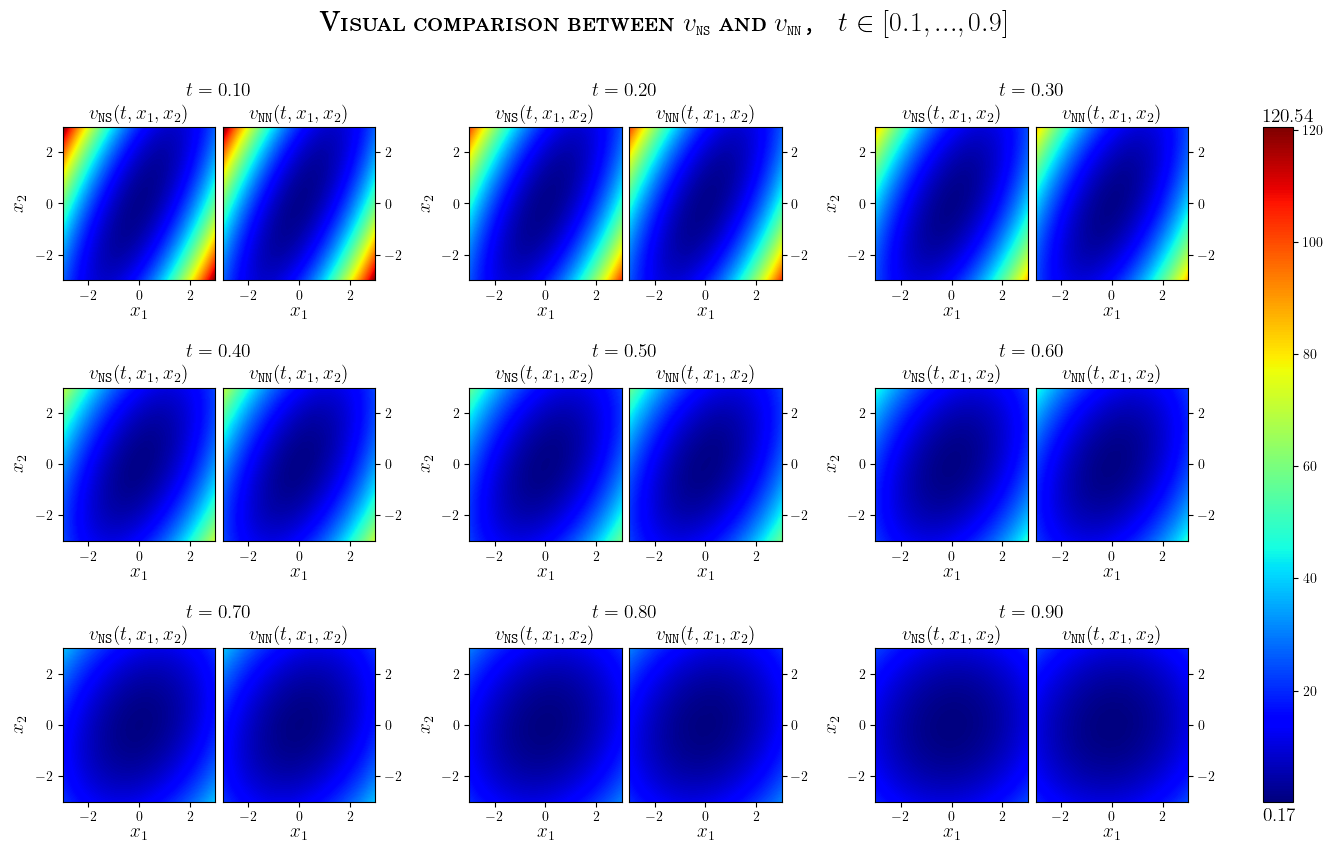

In [9]:
# Reshaping the numerical and neural network-based solutions for easier handling and visualization.
value_numerical_reshape = value_numerical.reshape([t_num, x_num[0] * x_num[1]]).view(t_num, x_num[0], x_num[1])
value_nn_reshape = value_nn.reshape([t_num, x_num[0] * x_num[1]]).view(t_num, x_num[0], x_num[1])

# Setting LaTeX style for the plots.
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{tgschola}')

# Determining global min and max values across both the numerical and NN-based solutions for consistent coloring.
value_min = torch.min(torch.cat((value_numerical, value_nn), dim=0)).detach().numpy()
value_max = torch.max(torch.cat((value_numerical, value_nn), dim=0)).detach().numpy()

# Creating a figure for visual comparison.
fig = plt.figure(figsize=(15, 9))
gs = gridspec.GridSpec(3, 3)  # GridSpec for a 3x3 layout.

cmap = 'jet'  # Color map for contour plots.
plt.subplots_adjust(left=0.1, right=0.85, bottom=0.1, top=0.85, wspace=0.3, hspace=0.7)

# Iterating over each time slice for visualization.
for i in range(len(t_batch_i)):
    subgs = gs[i // 3, i % 3].subgridspec(1, 2, wspace=0.05)  # SubGridSpec for side-by-side contour plots.
    
    # Left subplot for the numerical solution.
    ax_left = fig.add_subplot(subgs[0, 0])
    ax_left.contourf(X1.detach().numpy(), X2.detach().numpy(), value_numerical_reshape[i].detach().numpy(), levels=500, cmap=cmap, vmin=value_min, vmax=value_max)
    ax_left.set_title(r'$v_{\normalsize\texttt{NS}} (t,x_1,x_2)$', fontsize=14)
    ax_left.set_xlabel(r'$x_1$', labelpad=0, fontsize=14)
    ax_left.set_ylabel(r'$x_2$', labelpad=6, fontsize=14)
    
    # Right subplot for the neural network-based solution.
    ax_right = fig.add_subplot(subgs[0, 1])
    ax_right.contourf(X1.detach().numpy(), X2.detach().numpy(), value_nn_reshape[i].detach().numpy(), levels=500, cmap=cmap, vmin=value_min, vmax=value_max)
    ax_right.set_title(r'$v_{\normalsize\texttt{NN}}(t,x_1,x_2)$', fontsize=14)
    ax_right.set_xlabel(r'$x_1$', labelpad=0, fontsize=14)
    ax_right.tick_params(left=False, labelleft=False, right=True, labelright=True)
    
    # Position adjustments for the center title.
    pos_left = ax_left.get_position()
    pos_right = ax_right.get_position()
    middle_x = (pos_left.x1 + pos_right.x0) / 2  # Calculating the center x-coordinate.
    group_title = fr"$t = {{{t_batch_i[i]:.2f}}}$"
    fig.text(middle_x, pos_left.y1 + 0.03, group_title, ha='center', va='bottom', fontsize=14)


# x_positions = [0.17, 0.5, 0.83]  # 可能需要调整这些值以适应你的布局
# for i in range(3):
#     for j in range(3):
#         group_title = f"Group {i*3 + j + 1}: t = {t_batch_i[i*3 + j]:.2f}"
#         plt.figtext(x_positions[j], 0.88 - i*0.32, group_title, ha='center', fontsize=12)
# Adding a color bar for the contour plots.
cbaxes = fig.add_axes([0.90, 0.1, 0.02, 0.75])
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=value_min, vmax=value_max), cmap=cmap), cax=cbaxes, orientation='vertical')
cbar_ax_pos = cbar.ax.get_position()

text_x = cbar_ax_pos.x0 
text_y_min = cbar_ax_pos.y0  
text_y_max = cbar_ax_pos.y0 + cbar_ax_pos.height  
# Labeling the color bar's min and max values.
fig.text(text_x, text_y_min-0.025, fr'${{{value_min:.2f}}}$', va='bottom', ha='left',fontsize=14)
fig.text(text_x, text_y_max+0.02, fr'${{{value_max:.2f}}}$', va='top', ha='left',fontsize=14)

# Overall figure title.
fig.suptitle(r'{\rmfamily {\textsc{Visual comparison between}}  $v_{\normalsize \texttt{NS}}$ {\textsc{and}} $v_{\normalsize\texttt{NN}} ${\texttt{,  }}   $t \in [0.1,...,0.9]$}',fontsize=20)
# Displaying the figure in the notebook.
display(fig)
# Overall figure title.
plt.savefig('Exercise2/Exercise2_1_'+f'Comparion_over_time_horizon_{x_num[0]}x{x_num[1]}.eps', format='eps', dpi=600)
plt.savefig('Exercise2/Exercise2_1_'+f'Comparion_over_time_horizon_{x_num[0]}x{x_num[1]}.png', format='png', dpi=600)

In [10]:
# This class defines a neural network architecture for approximating the Markov control policy.
class MarkovControlNN(nn.Module):
    def __init__(self):
        # Inherits from nn.Module, making it a subclass of torch's module class, enabling model training and inference.
        super(MarkovControlNN, self).__init__()
        
        # Defining the first linear layer with input size 3 (time and 2D state) and output size 100.
        self.layer1 = nn.Linear(3, 100)
        
        # Defining the second linear layer where both input and output sizes are 100.
        self.layer2 = nn.Linear(100, 100)
        
        # Activation function to introduce non-linearity between layers, improving model's learning capability.
        self.relu = nn.ReLU()
        
        # The output layer that maps the internal representation to 2 outputs, representing the control actions.
        self.output = nn.Linear(100, 2)
    
    def forward(self, x):
        # Forward pass through the network:
        # Apply ReLU activation function after each linear transformation except for the output layer.
        x = self.relu(self.layer1(x))  # First transformation and activation
        x = self.relu(self.layer2(x))  # Second transformation and activation
        
        # No activation function after the output layer to allow the model to output raw control values.
        return self.output(x)  # Output layer transformation yielding the control policy approximation


In [11]:
# Initializing the Markov control neural network model with double precision for compatibility with the dataset
model_control = MarkovControlNN().double()

# Setting up the optimizer with Adam algorithm for optimizing model parameters with a learning rate of 0.001
optimizer_control = torch.optim.Adam(model_control.parameters(), lr=0.001)

# Using Mean Squared Error Loss as the criterion for evaluating model performance during training
criterion_control = nn.MSELoss()

# Prepare a list to record the average loss per epoch to visualize the training progress
epoch_losses_control = []

# Define training parameters
batch_size = 5  # Number of batches per training cycle
epochs = 1000  # Total number of training epochs

# Loop over each batch
for batch in range(batch_size):
    print(f'Batch {batch+1}/{batch_size}'+'\n')

    # Generate a new dataset for this batch, specifying 'control' to generate control data
    t_data, x_data, control_data = new_data(10000, 'control')

    # Prepare the inputs for the model by concatenating time and state data
    inputs = torch.cat((t_data.unsqueeze(-1), x_data.squeeze(1)), dim=1)
    
    # Create a dataset and dataloader for batch processing
    dataset = TensorDataset(inputs, control_data.squeeze(1))
    dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

    # Train the model for a specified number of epochs
    for epoch in range(epochs):
        model_control.train()  # Set the model to training mode
        total_loss = 0  # Reset total loss for this epoch

        # Loop over each batch of data
        for batch_idx, (data, target) in enumerate(dataloader):
            optimizer_control.zero_grad()  # Clear gradients
            output = model_control(data)  # Compute model output
            loss = criterion_control(output, target)  # Calculate loss
            loss.backward()  # Backpropagate the loss
            optimizer_control.step()  # Update model parameters
            total_loss += loss.item()  # Accumulate the loss

        # Record the average loss for this epoch
        epoch_losses_control.append(total_loss / len(dataloader))
        
        # Optionally print loss information at the start and at intervals during training
        if epoch == 0 or (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs} \t Loss: {total_loss / len(dataloader)}')
    print('\n')  # Print a newline after each batch for better readability


Batch 1/5

Epoch 1/1000 	 Loss: 37.80950477221523
Epoch 100/1000 	 Loss: 0.017939946080250912
Epoch 200/1000 	 Loss: 0.008504177202693555
Epoch 300/1000 	 Loss: 0.006201784381857976
Epoch 400/1000 	 Loss: 0.0048858858315881356
Epoch 500/1000 	 Loss: 0.004124694173918526
Epoch 600/1000 	 Loss: 0.002960423811563145
Epoch 700/1000 	 Loss: 0.00267782214254788
Epoch 800/1000 	 Loss: 0.002223596873161717
Epoch 900/1000 	 Loss: 0.00208982733434874
Epoch 1000/1000 	 Loss: 0.0018909694070517937


Batch 2/5

Epoch 1/1000 	 Loss: 0.003028368143730009
Epoch 100/1000 	 Loss: 0.00233126829751031
Epoch 200/1000 	 Loss: 0.0028519104485348707
Epoch 300/1000 	 Loss: 0.00248554593864186
Epoch 400/1000 	 Loss: 0.0018475369963181962
Epoch 500/1000 	 Loss: 0.0017255051860825626
Epoch 600/1000 	 Loss: 0.0016772380025940347
Epoch 700/1000 	 Loss: 0.0021101661999365314
Epoch 800/1000 	 Loss: 0.0017575074526654272
Epoch 900/1000 	 Loss: 0.001365775851648825
Epoch 1000/1000 	 Loss: 0.0012547624456555628


Batch 

C:\Users\warre\AppData\Local\Temp\ipykernel_27008\1554467069.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(min(epoch_losses_control) - 0.01, max(epoch_losses_control) + 0.01)


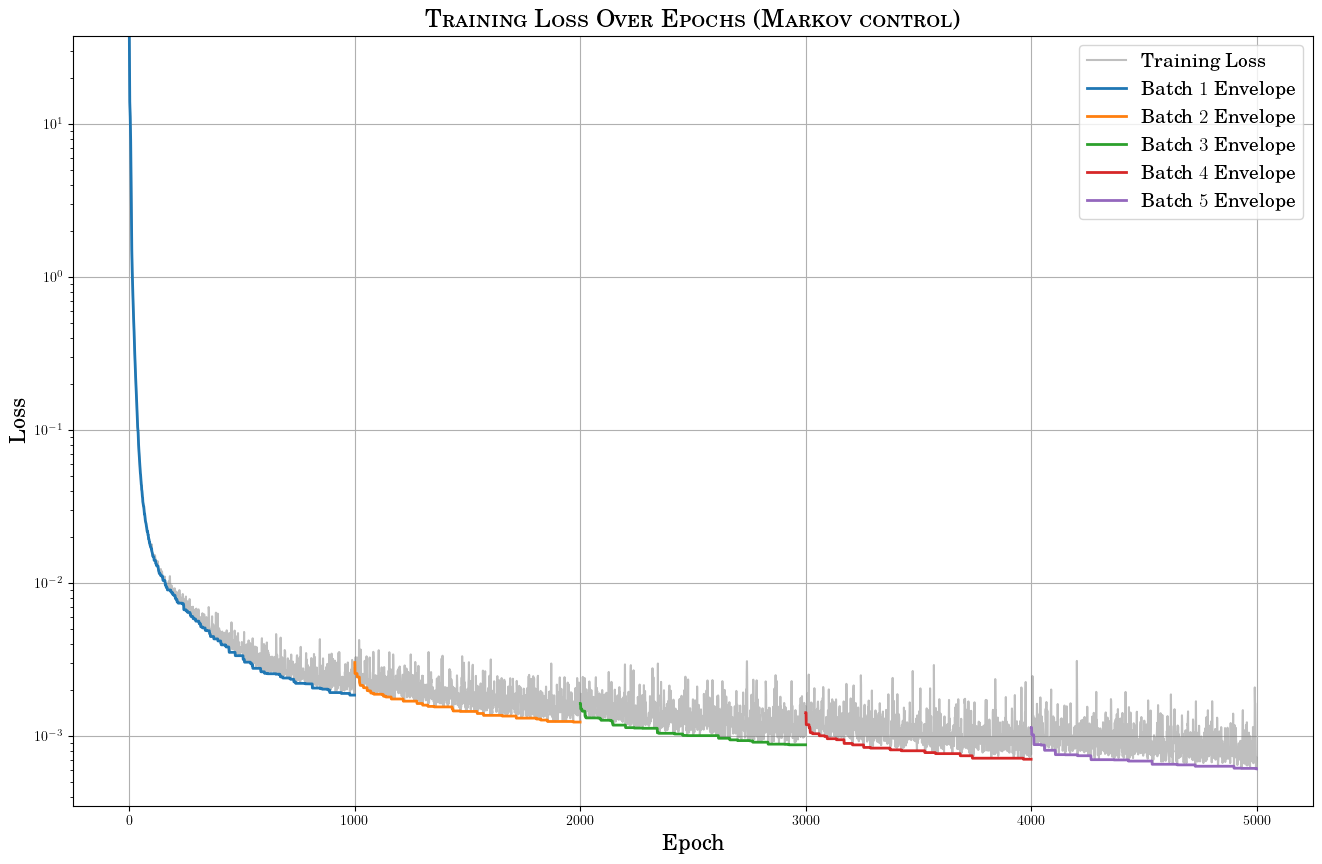

In [12]:
# Calculate the lower envelope of the training loss to highlight the best performance over time
envelope_lower = np.minimum.accumulate(epoch_losses_control)

# Initialize figure for plotting
plt.figure(figsize=(16, 10))

# Plot the raw training loss with semi-transparency to indicate fluctuation
plt.plot(epoch_losses_control, label=r'\rmfamily \textmd{Training Loss}', alpha=0.5, color='grey')

# Prepare a list of epoch numbers for x-axis
epoch_list = range(batch_size * epochs)

# Loop through each batch to plot its envelope
for i in range(batch_size):
    start = i * epochs  # Determine the start index for the current batch
    end = (i + 1) * epochs  # Determine the end index for the current batch
    batch_epochs = epoch_list[start:end]  # Select the epochs for the current batch
    batch_losses = epoch_losses_control[start:end]  # Select the losses for the current batch
    
    # Calculate the lower envelope of losses for the current batch
    envelope_lower = np.minimum.accumulate(batch_losses)
    
    # Plot the envelope for the current batch, highlighting the best performance
    plt.plot(batch_epochs, envelope_lower, label=r'\rmfamily \textmd {Batch }'+f'${i+1}$'+r'\rmfamily \textmd { Envelope}', lw=2)

# Set the y-axis to logarithmic scale to better visualize changes over orders of magnitude
plt.yscale('log')

# Label the x and y axes with appropriate descriptions and font settings
plt.xlabel(r'\rmfamily \textmd {Epoch}', fontsize=16)
plt.ylabel(r'\rmfamily \textmd {Loss}', fontsize=16)

# Set the title of the plot, emphasizing the focus on training loss for Markov control
plt.title(r'\rmfamily {\textsc{Training Loss Over Epochs (Markov control)}}', fontsize=18)

# Adjust the y-axis limits to closely frame the data while maintaining readability
plt.ylim(min(epoch_losses_control) - 0.01, max(epoch_losses_control) + 0.01)

# Display a legend to identify each batch's envelope
plt.legend(fontsize=14)

# Enable grid lines for easier interpretation of the plot
plt.grid(True)

# Save the plot as both EPS and PNG files for high-quality viewing and easy sharing
plt.savefig('Exercise2/Training Loss (Markov control).pdf', format='pdf', dpi=600)
plt.savefig('Exercise2/Training Loss (Markov control).png', format='png', dpi=600)

# Display the plot
plt.show()


In [13]:
# Save the trained Markov Control model to a file
# The model is saved as a .pth file, which is a common extension for PyTorch model files.
# This allows the model to be easily loaded in the future for further analysis, evaluation, or deployment.
torch.save(model_control, 'Exercise2/control_model.pth')
